# Bragg Reflector

The band structure of light propagating in vacuum is a straight line. This is the dispersion relation of light. What happens if we add a periodicity to our medium? At zone boundaries, the bands are continuous and we have band folding. If we create a periodic index profile (like a diffraction grating) and inject light with a fiber at a proper angle, a band gap can appear in the dispersion relation, where of course reflectance will be very high.  

If at some point i remove a layer (introducing a defect), a cavity appears and plays the role of a frequency filter. At this point we have 2 frequency with high reflectance in a given band forming our cavity. 

One can prove that the reflectance is maximised if

$$ d_{(1,2)} = \frac{\lambda_0}{4 n_{(1,2)}} $$

We will need a source and two monitors. In between, a certain number of periods of this structure $\approx 10$. If the number is odd, it is easy to create a symmetric defect. We need very wide monitors to avoid losses in our measurement. We need to leave some space (e.g. $5a$) between the monitors and the periodic stucture inside.

Good values are $n_1 = 1.45$, $n_2 = 2.9$, $f=0.645$, $df=0.5$. The width of the gap depends on the index contrast:

$$ \frac{\Delta\omega}{\omega} \propto \Delta n $$

In [26]:
# Import packages 

import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
import scipy.signal as sp
import scipy.stats as spst


-----------
Initializing structure...
time for choose_chunkdivision = 0.000453949 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 16
     block, center = (1.68667,0,0)
          size (5.37333,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.586667,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.173333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (0.24,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (0.653333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          diel

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 189.09375/328.5714282989502 = 57.6% done in 4.0s, 3.0s to go
on time step 6068 (time=189.625), 0.000659241 s/step
run 0 finished at t = 328.59375 (10515 timesteps)


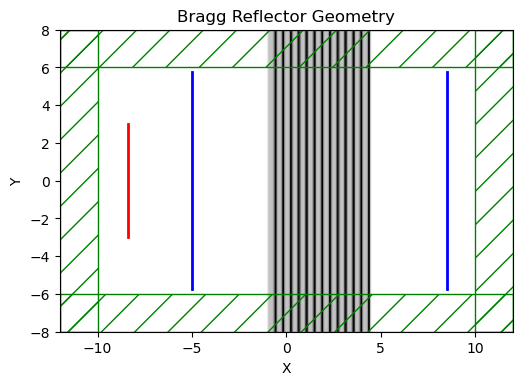

In [29]:
# Start by defining the simulation domain

sy = 16

res = 16

# Refractive index parameters

n_high = 2.5
n_low = 1.5
dpml = 2 

# Frequency parameters

wl = 1.55  
freq = 1 / wl 
df = 0.35
nfreq = 500


# Unit conversion parameters

a = 2 *1e-6 # Let us use this as a length scale.. it seems to make sense, realistically
c = 2.99792548 *1e8 # Speed of light 
courant = 0.5 

f_conv = (c*courant*res) / a

# Layers 

l_high = wl / (4 * n_high) # This is 310 nm thick

l_low = wl / (4 * n_low) # and this is 516 nm

# These thicknesses seem reasonable.

period = l_high + l_low

n_p = 13

thck = n_p * period  # The whole thickness is  10.74 microns

space_front = 8
space_back = 4

sx = np.ceil(2 * dpml + space_front + space_back + thck + 2)
sy = 16

# Meep function to define the domain. 

cell = mp.Vector3(sx, sy)

# Now we define the geomtry. This has to be done iteratively. 1st layer at low index. 

# First, make a block of index n_low

geometry = [mp.Block(
           mp.Vector3(thck, mp.inf, mp.inf), #
           center = mp.Vector3((dpml + space_front + thck/2) - sx/2 +1,0,0),  
           material = mp.Medium(index = n_low)) ] 


for jj in range(0, n_p):
    
    geometry.append( 
        mp.Block(
           mp.Vector3(l_high, mp.inf, mp.inf), #
           center = mp.Vector3((dpml + space_front + (jj+1)*period) -sx/2 +1, 0,0),  
           material = mp.Medium(index = n_high))
    )



# Now define a source

sources = [mp.Source(mp.GaussianSource(frequency=freq, fwidth = df), # Type of source
                     component = mp.Ez, 
                     size = mp.Vector3(0,6,0),
                     center = mp.Vector3(-sx/2 + 1.8*dpml,0))] # Position

# Boundary condition, we use PML layer

pml_layer = [mp.PML(dpml) ] 

# Define Simulation

sim = mp.Simulation(
      cell_size = cell,
      boundary_layers = pml_layer,
      geometry = geometry,
      sources = sources,
      resolution = res)

# Define Flux region for Transmitted Field

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 1.5, 0, 0), size = mp.Vector3(0,11.5,0) )
trans = sim.add_flux(freq, df, nfreq, tr_fr)

re_fr = mp.FluxRegion(center=mp.Vector3(-sx/2 + dpml + 5, 0, 0), size = mp.Vector3(0,11.5,0) )
refl = sim.add_flux(freq, df, nfreq, re_fr)


# Run Simulation

sim.run(until_after_sources=300) 
#sim.run(mp.at_every(10, mp.output_png(mp.Ez,"-Zc dkbluered")), until_after_sources=300) 

# Now Get Fluxes

straight_tr_fl = mp.get_fluxes(trans)
straight_re_fl = mp.get_fluxes(refl)
fl_fr = mp.get_flux_freqs(refl)

str_re_data = sim.get_flux_data(refl)

# plot the dielectric structure 

plt.figure(dpi=100)
sim.plot2D()
plt.title("Bragg Reflector Geometry")
plt.savefig("bragg_geom.png", dpi = 150, format = "png")
plt.show()


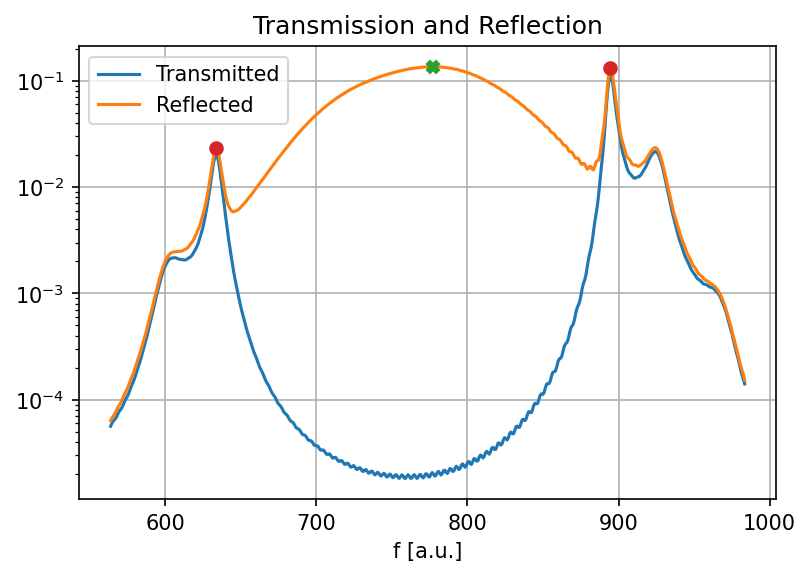

In [32]:
# Now we find delta omega / omega 

half = int(np.floor(len(straight_tr_fl)/2)) 

ind_inf = np.argmax(straight_tr_fl[0:half]) # first peak of transmission before reflection window

ind_min = ind_inf + np.argmin(straight_re_fl[ind_inf:half]) # minimum of reflection before reflection window

ind_sup = half + np.argmax(straight_tr_fl[half:]) # transmission peak after reflection window

ind_max = half + np.argmin(straight_re_fl[half:ind_sup]) # minimum of reflection after reflection window

# Find peak

peak_loc = ind_min + np.argmax(straight_re_fl[ind_min:ind_max]) 

pk = np.max(straight_re_fl[ind_min:ind_max]) 

# Find width

gap_width = fl_fr[ind_sup]-fl_fr[ind_inf]

# plot the fluxes

fig = plt.figure(dpi=150)

#fl_fr = np.array(fl_fr) * f_conv / 1e12

plt.plot(fl_fr, np.abs(straight_tr_fl), label="Transmitted")
plt.plot(fl_fr, np.abs(straight_re_fl), label ="Reflected")
plt.plot(fl_fr[ind_inf], np.abs(straight_re_fl)[ind_inf], "o", color= "C3") 
plt.plot(fl_fr[ind_sup], np.abs(straight_re_fl)[ind_sup], "o", color= "C3") 
plt.plot(fl_fr[peak_loc], np.abs(straight_re_fl)[peak_loc], "X" )
plt.yscale("log")
plt.legend()
plt.grid()
plt.xlabel("f [a.u.]")
plt.title("Transmission and Reflection")

plt.savefig("finding_peak.png", dpi = 150, format = "png")

plt.show()


# Study The Refractive Index Contrast Dependence

Change the index contrast and do the same simulation over and over 

In [22]:
sim.reset_meep()

# NOTICE, IMPORTANT. THE MAXIMUM INDEX CONTRAST WE CAN USE IS LIMITED BY THE RESOLUTION WE CHOOSE
# FOR EXAMPLE, IF THE RESOLUTION IS 10 WE ARE LIMITED TO ABOUT 1 IN THE CONTRAST
# YOU COULD TRY TO UNDERSTAND WHY

# Refractive index parameters

nsize = 100
n_high_vec = np.linspace(1.9,3.6,nsize)
n_low = 1.5
dpml = 2 

# Frequency parameters

wl = 1.55
freq = 1 / wl
df = 0.35
nfreq = 500

# Now we start the geometry definition. This has to be done iteratively.

l_low = wl / (4 * n_low)

# Other things that do not depend on n_high

space_front = 8
space_back = 4

sy = 16
res = 14

# PML does not depend on n_high

pml_layer = [mp.PML(dpml) ] 


# Make a vector to store the result

norm_gap = np.zeros(len(n_high_vec))

# Now start with the n_high dependent part 

i = 0

for n_high in n_high_vec:
    
    # Layers 

    l_high = wl / (4 * n_high)

    period = l_high + l_low

    n_p = 13

    thck = n_p * period

    sx = np.ceil(2 * dpml + space_front + space_back + thck + 2)

    # Meep function to define the domain. 

    cell = mp.Vector3(sx, sy)
    
    # We start with the fixed block with index n_low
 

    geometry = [mp.Block(
               mp.Vector3(thck, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + thck/2) - sx/2 +1,0,0),  
               material = mp.Medium(index = n_low)) ] 

    # Now append the "stripes" of higher refractive index to the geometry 
    
    for jj in range(0, n_p):

        geometry.append( 
            mp.Block(
               mp.Vector3(l_high, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + (jj+1)*period) -sx/2 +1, 0,0),  
               material = mp.Medium(index = n_high))
        )
        
    #Source 

    sources = [mp.Source(mp.GaussianSource(frequency=freq, fwidth = df), # Type of source
                         component = mp.Ez, 
                         size = mp.Vector3(0,6,0),
                         center = mp.Vector3(-sx/2 + 1.8*dpml,0))] # Position

    # Define Simulation

    sim = mp.Simulation(
          cell_size = cell,
          boundary_layers = pml_layer,
          geometry = geometry,
          sources = sources,
          resolution = res)

    # Define Flux region for Transmitted Field

    tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 1.5, 0, 0), size = mp.Vector3(0,11.5,0) )
    trans = sim.add_flux(freq, df, nfreq, tr_fr)

    re_fr = mp.FluxRegion(center=mp.Vector3(-sx/2 + dpml + 5, 0, 0), size = mp.Vector3(0,11.5,0) )
    refl = sim.add_flux(freq, df, nfreq, re_fr)


    # Run Simulation

    sim.run(until_after_sources=300) 
    #sim.run(mp.at_every(10, mp.output_png(mp.Ez,"-Zc dkbluered")), until_after_sources=300) 

    # Now Get Fluxes

    straight_tr_fl = mp.get_fluxes(trans)
    straight_re_fl = mp.get_fluxes(refl)
    fl_fr = mp.get_flux_freqs(refl)

    str_re_data = sim.get_flux_data(refl)

    # Now we find delta omega / omega 

    half = int(np.floor(len(straight_tr_fl)/2)) 

    ind_inf = np.argmax(straight_tr_fl[0:half]) # first peak of transmission before reflection window

    ind_min = ind_inf + np.argmin(straight_re_fl[ind_inf:half]) # minimum of reflection before reflection window

    ind_sup = half + np.argmax(straight_tr_fl[half:]) # transmission peak after reflection window

    ind_max = half + np.argmin(straight_re_fl[half:ind_sup]) # minimum of reflection after reflection window

    # Find peak

    peak_loc = ind_min + np.argmax(straight_re_fl[ind_min:ind_max]) 

    pk = np.max(straight_re_fl[ind_min:ind_max]) 

    # Find width
    
    gap_width = fl_fr[ind_sup]-fl_fr[ind_inf]
    
    norm_gap[i] = gap_width / fl_fr[peak_loc]
 
    i += 1


-----------
Initializing structure...
time for choose_chunkdivision = 0.000213861 s
Working in 2D dimensions.
Computational cell is 25 x 16 x 0 with resolution 14
     block, center = (1.50482,0,0)
          size (6.00965,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.03772,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-0.575439,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-0.113158,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0.349123,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 284.4642857142857/328.5714282989502 = 86.6% done in 4.0s, 0.6s to go
on time step 7991 (time=285.393), 0.000500597 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000237942 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.99295,0,0)
          size (5.9859,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.539546,0,0)
          size (0.202121,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.67555,3.67555,3.67555)
     block, center = (-0.079092,0,0)
          size (0.202121,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.67555,3.67555,3.67555)
     block, center = (0.381362,0,0)
          size (0.202121,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 306.85714285714283/328.5714282989502 = 93.4% done in 4.0s, 0.3s to go
on time step 8603 (time=307.25), 0.000464963 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000408173 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.98129,0,0)
          size (5.96258,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.54134,0,0)
          size (0.200326,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.74168,3.74168,3.74168)
     block, center = (-0.0826806,0,0)
          size (0.200326,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.74168,3.74168,3.74168)
     block, center = (0.375979,0,0)
          size (0.200326,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 295.3928571428571/328.5714282989502 = 89.9% done in 4.0s, 0.4s to go
on time step 8283 (time=295.821), 0.000482996 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000218868 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.96983,0,0)
          size (5.93966,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.543103,0,0)
          size (0.198564,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.80841,3.80841,3.80841)
     block, center = (-0.086206,0,0)
          size (0.198564,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.80841,3.80841,3.80841)
     block, center = (0.370691,0,0)
          size (0.198564,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 257.6785714285714/328.5714282989502 = 78.4% done in 4.0s, 1.1s to go
on time step 7227 (time=258.107), 0.000553484 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000240803 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.95857,0,0)
          size (5.91715,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.544835,0,0)
          size (0.196832,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.87573,3.87573,3.87573)
     block, center = (-0.0896699,0,0)
          size (0.196832,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.87573,3.87573,3.87573)
     block, center = (0.365495,0,0)
          size (0.196832,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 240.53571428571428/328.5714282989502 = 73.2% done in 4.0s, 1.5s to go
on time step 6751 (time=241.107), 0.000592567 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000311852 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.94751,0,0)
          size (5.89502,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.546537,0,0)
          size (0.19513,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.94363,3.94363,3.94363)
     block, center = (-0.0930739,0,0)
          size (0.19513,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.94363,3.94363,3.94363)
     block, center = (0.360389,0,0)
          size (0.19513,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 280.32142857142856/328.5714282989502 = 85.3% done in 4.0s, 0.7s to go
on time step 7860 (time=280.714), 0.000508916 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000365973 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.93664,0,0)
          size (5.87327,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.54821,0,0)
          size (0.193457,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.01213,4.01213,4.01213)
     block, center = (-0.0964196,0,0)
          size (0.193457,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.01213,4.01213,4.01213)
     block, center = (0.355371,0,0)
          size (0.193457,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 278.6428571428571/328.5714282989502 = 84.8% done in 4.0s, 0.7s to go
on time step 7817 (time=279.179), 0.000511749 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000280857 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.92595,0,0)
          size (5.8519,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.549854,0,0)
          size (0.191812,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.08122,4.08122,4.08122)
     block, center = (-0.0997083,0,0)
          size (0.191812,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.08122,4.08122,4.08122)
     block, center = (0.350437,0,0)
          size (0.191812,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 273.3928571428571/328.5714282989502 = 83.2% done in 4.0s, 0.8s to go
on time step 7669 (time=273.893), 0.000521627 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000212908 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.91544,0,0)
          size (5.83088,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.551471,0,0)
          size (0.190196,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.15089,4.15089,4.15089)
     block, center = (-0.102942,0,0)
          size (0.190196,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.15089,4.15089,4.15089)
     block, center = (0.345588,0,0)
          size (0.190196,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 242.82142857142856/328.5714282989502 = 73.9% done in 4.0s, 1.4s to go
on time step 6807 (time=243.107), 0.000587635 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000219107 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.90511,0,0)
          size (5.81021,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.55306,0,0)
          size (0.188606,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.22116,4.22116,4.22116)
     block, center = (-0.106121,0,0)
          size (0.188606,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.22116,4.22116,4.22116)
     block, center = (0.340819,0,0)
          size (0.188606,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 292.7857142857143/328.5714282989502 = 89.1% done in 4.0s, 0.5s to go
on time step 8208 (time=293.143), 0.000487369 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000208139 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.89495,0,0)
          size (5.78989,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.554624,0,0)
          size (0.187043,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.29201,4.29201,4.29201)
     block, center = (-0.109248,0,0)
          size (0.187043,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.29201,4.29201,4.29201)
     block, center = (0.336129,0,0)
          size (0.187043,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 274.60714285714283/328.5714282989502 = 83.6% done in 4.0s, 0.8s to go
on time step 7700 (time=275), 0.000519491 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000300884 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.88495,0,0)
          size (5.7699,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.556161,0,0)
          size (0.185505,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.36346,4.36346,4.36346)
     block, center = (-0.112323,0,0)
          size (0.185505,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.36346,4.36346,4.36346)
     block, center = (0.331516,0,0)
          size (0.185505,1e+20,1e+20)
          a

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 304.2857142857143/328.5714282989502 = 92.6% done in 4.0s, 0.3s to go
on time step 8531 (time=304.679), 0.000468915 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000206947 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.87512,0,0)
          size (5.75024,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.557674,0,0)
          size (0.183993,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.43549,4.43549,4.43549)
     block, center = (-0.115348,0,0)
          size (0.183993,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.43549,4.43549,4.43549)
     block, center = (0.326978,0,0)
          size (0.183993,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 273.7142857142857/328.5714282989502 = 83.3% done in 4.0s, 0.8s to go
on time step 7672 (time=274), 0.00052138 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000301123 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.86545,0,0)
          size (5.7309,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.559162,0,0)
          size (0.182505,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.50812,4.50812,4.50812)
     block, center = (-0.118324,0,0)
          size (0.182505,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.50812,4.50812,4.50812)
     block, center = (0.322514,0,0)
          size (0.182505,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 291.7857142857143/328.5714282989502 = 88.8% done in 4.0s, 0.5s to go
on time step 8182 (time=292.214), 0.000488917 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000210047 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.85593,0,0)
          size (5.71186,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.560626,0,0)
          size (0.181041,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.58133,4.58133,4.58133)
     block, center = (-0.121252,0,0)
          size (0.181041,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.58133,4.58133,4.58133)
     block, center = (0.318122,0,0)
          size (0.181041,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 272.85714285714283/328.5714282989502 = 83.0% done in 4.0s, 0.8s to go
on time step 7653 (time=273.321), 0.0005227 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000226974 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.84656,0,0)
          size (5.69313,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.562067,0,0)
          size (0.1796,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.65513,4.65513,4.65513)
     block, center = (-0.124134,0,0)
          size (0.1796,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.65513,4.65513,4.65513)
     block, center = (0.313799,0,0)
          size (0.1796,1e+20,1e+20)
          axes

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 293.3928571428571/328.5714282989502 = 89.3% done in 4.0s, 0.5s to go
on time step 8226 (time=293.786), 0.000486316 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000269175 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.83735,0,0)
          size (5.67469,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.563485,0,0)
          size (0.178182,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.72953,4.72953,4.72953)
     block, center = (-0.12697,0,0)
          size (0.178182,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.72953,4.72953,4.72953)
     block, center = (0.309545,0,0)
          size (0.178182,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 218.57142857142856/328.5714282989502 = 66.5% done in 4.0s, 2.0s to go
on time step 6127 (time=218.821), 0.000652868 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000201941 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.82827,0,0)
          size (5.65655,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.564881,0,0)
          size (0.176786,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.80451,4.80451,4.80451)
     block, center = (-0.129762,0,0)
          size (0.176786,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.80451,4.80451,4.80451)
     block, center = (0.305357,0,0)
          size (0.176786,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 273.32142857142856/328.5714282989502 = 83.2% done in 4.0s, 0.8s to go
on time step 7669 (time=273.893), 0.000521581 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000239134 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.81934,0,0)
          size (5.63868,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.566255,0,0)
          size (0.175412,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.88008,4.88008,4.88008)
     block, center = (-0.13251,0,0)
          size (0.175412,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.88008,4.88008,4.88008)
     block, center = (0.301235,0,0)
          size (0.175412,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 287.1428571428571/328.5714282989502 = 87.4% done in 4.0s, 0.6s to go
on time step 8050 (time=287.5), 0.000496918 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000240803 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.81055,0,0)
          size (5.62109,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.567608,0,0)
          size (0.174059,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.95625,4.95625,4.95625)
     block, center = (-0.135216,0,0)
          size (0.174059,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.95625,4.95625,4.95625)
     block, center = (0.297176,0,0)
          size (0.174059,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 264.7142857142857/328.5714282989502 = 80.6% done in 4.0s, 1.0s to go
on time step 7425 (time=265.179), 0.000538854 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000225067 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.80189,0,0)
          size (5.60377,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.56894,0,0)
          size (0.172726,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.033,5.033,5.033)
     block, center = (-0.137881,0,0)
          size (0.172726,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.033,5.033,5.033)
     block, center = (0.293179,0,0)
          size (0.172726,1e+20,1e+20)
          axes (1,0,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 280.0/328.5714282989502 = 85.2% done in 4.0s, 0.7s to go
on time step 7855 (time=280.536), 0.000509364 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000215054 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.79336,0,0)
          size (5.58672,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.570252,0,0)
          size (0.171414,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.11034,5.11034,5.11034)
     block, center = (-0.140505,0,0)
          size (0.171414,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.11034,5.11034,5.11034)
     block, center = (0.289243,0,0)
          size (0.171414,1e+20,1e+20)
          axes (1,0

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 277.7857142857143/328.5714282989502 = 84.5% done in 4.0s, 0.7s to go
on time step 7793 (time=278.321), 0.000513332 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000207901 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.78496,0,0)
          size (5.56992,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.571545,0,0)
          size (0.170122,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.18827,5.18827,5.18827)
     block, center = (-0.143089,0,0)
          size (0.170122,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.18827,5.18827,5.18827)
     block, center = (0.285366,0,0)
          size (0.170122,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 293.5357142857143/328.5714282989502 = 89.3% done in 4.0s, 0.5s to go
on time step 8231 (time=293.964), 0.000485982 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000221014 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.77669,0,0)
          size (5.55337,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.572818,0,0)
          size (0.168849,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.26679,5.26679,5.26679)
     block, center = (-0.145635,0,0)
          size (0.168849,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.26679,5.26679,5.26679)
     block, center = (0.281547,0,0)
          size (0.168849,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

KeyboardInterrupt: 

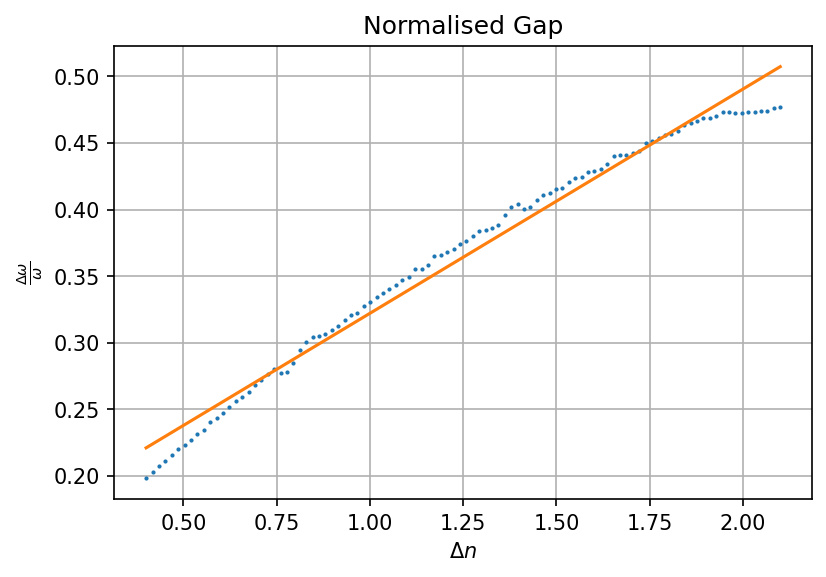

In [9]:
# Now make a figure 

delta_n = n_high_vec - np.ones(len(n_high_vec)) * n_low


slope, intercept, r, p, se = spst.linregress(delta_n, norm_gap, alternative='greater')


fig, ax = plt.subplots(dpi=150)

ax.plot(delta_n, norm_gap, ".", markersize = 2)
ax.plot(delta_n, intercept + delta_n * slope)
ax.set_xlabel(r"$\Delta n$")
ax.set_ylabel(r"$\frac{\Delta\omega}{\omega}$")
plt.title("Normalised Gap")
plt.grid()
plt.savefig("gap_dependence.png", dpi = 150, format="png")

plt.show()


In [10]:
sim.reset_meep()

# NOTICE, IMPORTANT. THE MAXIMUM INDEX CONTRAST WE CAN USE IS LIMITED BY THE RESOLUTION WE CHOOSE
# FOR EXAMPLE, IF THE RESOLUTION IS 10 WE ARE LIMITED TO ABOUT 1 IN THE CONTRAST
# YOU COULD TRY TO UNDERSTAND WHY

# Refractive index parameters

nsize = 50
n_high_vec = np.linspace(1.9,2.5,nsize)
n_low = 1.5
dpml = 2 

# Frequency parameters

wl = 1.55
freq = 1 / wl
df = 0.35
nfreq = 500

# Now we start the geometry definition. This has to be done iteratively.

l_low = wl / (4 * n_low)

# Other things that do not depend on n_high

space_front = 8
space_back = 4

sy = 16
res = 14

# PML does not depend on n_high

pml_layer = [mp.PML(dpml) ] 


# Make a vector to store the result

norm_gap = np.zeros(len(n_high_vec))

# Now start with the n_high dependent part 

i = 0

for n_high in n_high_vec:
    
    # Layers 

    l_high = wl / (4 * n_high)

    period = l_high + l_low

    n_p = 13

    thck = n_p * period

    sx = np.ceil(2 * dpml + space_front + space_back + thck + 2)

    # Meep function to define the domain. 

    cell = mp.Vector3(sx, sy)
    
    # We start with the fixed block with index n_low
 

    geometry = [mp.Block(
               mp.Vector3(thck, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + thck/2) - sx/2 +1,0,0),  
               material = mp.Medium(index = n_low)) ] 

    # Now append the "stripes" of higher refractive index to the geometry 
    
    for jj in range(0, n_p):

        geometry.append( 
            mp.Block(
               mp.Vector3(l_high, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + (jj+1)*period) -sx/2 +1, 0,0),  
               material = mp.Medium(index = n_high))
        )
        
    #Source 

    sources = [mp.Source(mp.GaussianSource(frequency=freq, fwidth = df), # Type of source
                         component = mp.Ez, 
                         size = mp.Vector3(0,6,0),
                         center = mp.Vector3(-sx/2 + 1.8*dpml,0))] # Position

    # Define Simulation

    sim = mp.Simulation(
          cell_size = cell,
          boundary_layers = pml_layer,
          geometry = geometry,
          sources = sources,
          resolution = res)

    # Define Flux region for Transmitted Field

    tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 1.5, 0, 0), size = mp.Vector3(0,11.5,0) )
    trans = sim.add_flux(freq, df, nfreq, tr_fr)

    re_fr = mp.FluxRegion(center=mp.Vector3(-sx/2 + dpml + 5, 0, 0), size = mp.Vector3(0,11.5,0) )
    refl = sim.add_flux(freq, df, nfreq, re_fr)


    # Run Simulation

    sim.run(until_after_sources=300) 
    #sim.run(mp.at_every(10, mp.output_png(mp.Ez,"-Zc dkbluered")), until_after_sources=300) 

    # Now Get Fluxes

    straight_tr_fl = mp.get_fluxes(trans)
    straight_re_fl = mp.get_fluxes(refl)
    fl_fr = mp.get_flux_freqs(refl)

    str_re_data = sim.get_flux_data(refl)

    # Now we find delta omega / omega 

    half = int(np.floor(len(straight_tr_fl)/2)) 

    ind_inf = np.argmax(straight_tr_fl[0:half]) # first peak of transmission before reflection window

    ind_min = ind_inf + np.argmin(straight_re_fl[ind_inf:half]) # minimum of reflection before reflection window

    ind_sup = half + np.argmax(straight_tr_fl[half:]) # transmission peak after reflection window

    ind_max = half + np.argmin(straight_re_fl[half:ind_sup]) # minimum of reflection after reflection window

    # Find peak

    peak_loc = ind_min + np.argmax(straight_re_fl[ind_min:ind_max]) 

    pk = np.max(straight_re_fl[ind_min:ind_max]) 

    
    fwhm = fl_fr[ind_sup]-fl_fr[ind_inf]
    
    norm_gap[i] = fwhm / fl_fr[peak_loc]
 
    i += 1


-----------
Initializing structure...
time for choose_chunkdivision = 0.000225067 s
Working in 2D dimensions.
Computational cell is 25 x 16 x 0 with resolution 14
     block, center = (1.50482,0,0)
          size (6.00965,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-1.03772,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-0.575439,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (-0.113158,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0.349123,0,0)
          size (0.203947,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 259.1428571428571/328.5714282989502 = 78.9% done in 4.0s, 1.1s to go
on time step 7271 (time=259.679), 0.00055021 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000224829 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.99634,0,0)
          size (5.99267,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.539025,0,0)
          size (0.202641,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.65668,3.65668,3.65668)
     block, center = (-0.0780505,0,0)
          size (0.202641,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.65668,3.65668,3.65668)
     block, center = (0.382924,0,0)
          size (0.202641,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 273.4642857142857/328.5714282989502 = 83.2% done in 4.0s, 0.8s to go
on time step 7669 (time=273.893), 0.000521586 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000236034 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.98796,0,0)
          size (5.97591,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.540315,0,0)
          size (0.201352,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.70366,3.70366,3.70366)
     block, center = (-0.0806292,0,0)
          size (0.201352,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.70366,3.70366,3.70366)
     block, center = (0.379056,0,0)
          size (0.201352,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 255.35714285714283/328.5714282989502 = 77.7% done in 4.0s, 1.1s to go
on time step 7158 (time=255.643), 0.00055882 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000360012 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.97968,0,0)
          size (5.95936,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.541588,0,0)
          size (0.200079,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.75094,3.75094,3.75094)
     block, center = (-0.0831753,0,0)
          size (0.200079,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.75094,3.75094,3.75094)
     block, center = (0.375237,0,0)
          size (0.200079,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 266.8928571428571/328.5714282989502 = 81.2% done in 4.0s, 0.9s to go
on time step 7486 (time=267.357), 0.000534363 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265121 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.97151,0,0)
          size (5.94302,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.542845,0,0)
          size (0.198822,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.79852,3.79852,3.79852)
     block, center = (-0.0856894,0,0)
          size (0.198822,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.79852,3.79852,3.79852)
     block, center = (0.371466,0,0)
          size (0.198822,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 292.9642857142857/328.5714282989502 = 89.2% done in 4.0s, 0.5s to go
on time step 8216 (time=293.429), 0.000486884 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000372171 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.96344,0,0)
          size (5.92688,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.544086,0,0)
          size (0.197581,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8464,3.8464,3.8464)
     block, center = (-0.088172,0,0)
          size (0.197581,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.8464,3.8464,3.8464)
     block, center = (0.367742,0,0)
          size (0.197581,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 292.1785714285714/328.5714282989502 = 88.9% done in 4.0s, 0.5s to go
on time step 8193 (time=292.607), 0.000488259 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000221968 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.95547,0,0)
          size (5.91094,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.545312,0,0)
          size (0.196355,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.89458,3.89458,3.89458)
     block, center = (-0.0906239,0,0)
          size (0.196355,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.89458,3.89458,3.89458)
     block, center = (0.364064,0,0)
          size (0.196355,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 295.2142857142857/328.5714282989502 = 89.8% done in 4.0s, 0.5s to go
on time step 8280 (time=295.714), 0.000483199 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000241995 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.9476,0,0)
          size (5.8952,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.546523,0,0)
          size (0.195144,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.94306,3.94306,3.94306)
     block, center = (-0.0930456,0,0)
          size (0.195144,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.94306,3.94306,3.94306)
     block, center = (0.360432,0,0)
          size (0.195144,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 298.2857142857143/328.5714282989502 = 90.8% done in 4.0s, 0.4s to go
on time step 8361 (time=298.607), 0.000478459 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000243902 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.93983,0,0)
          size (5.87966,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.547719,0,0)
          size (0.193948,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.99184,3.99184,3.99184)
     block, center = (-0.0954375,0,0)
          size (0.193948,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.99184,3.99184,3.99184)
     block, center = (0.356844,0,0)
          size (0.193948,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 302.6785714285714/328.5714282989502 = 92.1% done in 4.0s, 0.3s to go
on time step 8488 (time=303.143), 0.000471274 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000239134 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.93215,0,0)
          size (5.8643,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.5489,0,0)
          size (0.192766,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.04092,4.04092,4.04092)
     block, center = (-0.0978003,0,0)
          size (0.192766,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.04092,4.04092,4.04092)
     block, center = (0.353299,0,0)
          size (0.192766,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.7142857142857/328.5714282989502 = 91.2% done in 4.0s, 0.4s to go
on time step 8402 (time=300.071), 0.000476095 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000379086 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.92456,0,0)
          size (5.84913,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.550067,0,0)
          size (0.191599,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.0903,4.0903,4.0903)
     block, center = (-0.100135,0,0)
          size (0.191599,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.0903,4.0903,4.0903)
     block, center = (0.349798,0,0)
          size (0.191599,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 296.25/328.5714282989502 = 90.2% done in 4.0s, 0.4s to go
on time step 8309 (time=296.75), 0.000481414 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000236988 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.91707,0,0)
          size (5.83414,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.55122,0,0)
          size (0.190446,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.13998,4.13998,4.13998)
     block, center = (-0.102441,0,0)
          size (0.190446,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.13998,4.13998,4.13998)
     block, center = (0.346339,0,0)
          size (0.190446,1e+20,1e+20)
          axes (1,0,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 295.82142857142856/328.5714282989502 = 90.0% done in 4.0s, 0.4s to go
on time step 8295 (time=296.25), 0.000482293 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000342131 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.90966,0,0)
          size (5.81933,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.55236,0,0)
          size (0.189307,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.18996,4.18996,4.18996)
     block, center = (-0.104719,0,0)
          size (0.189307,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.18996,4.18996,4.18996)
     block, center = (0.342921,0,0)
          size (0.189307,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 292.0357142857143/328.5714282989502 = 88.9% done in 4.0s, 0.5s to go
on time step 8190 (time=292.5), 0.000488573 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00028801 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.90235,0,0)
          size (5.80469,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.553485,0,0)
          size (0.188181,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.24024,4.24024,4.24024)
     block, center = (-0.106971,0,0)
          size (0.188181,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.24024,4.24024,4.24024)
     block, center = (0.339544,0,0)
          size (0.188181,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 293.4285714285714/328.5714282989502 = 89.3% done in 4.0s, 0.5s to go
on time step 8230 (time=293.929), 0.000486051 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.00031209 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.89511,0,0)
          size (5.79023,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.554598,0,0)
          size (0.187069,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.29082,4.29082,4.29082)
     block, center = (-0.109195,0,0)
          size (0.187069,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.29082,4.29082,4.29082)
     block, center = (0.336207,0,0)
          size (0.187069,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 292.9642857142857/328.5714282989502 = 89.2% done in 4.0s, 0.5s to go
on time step 8216 (time=293.429), 0.000486868 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000218868 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.88797,0,0)
          size (5.77594,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.555697,0,0)
          size (0.18597,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.3417,4.3417,4.3417)
     block, center = (-0.111394,0,0)
          size (0.18597,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.3417,4.3417,4.3417)
     block, center = (0.332909,0,0)
          size (0.18597,1e+20,1e+20)
          axes (

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 297.9285714285714/328.5714282989502 = 90.7% done in 4.0s, 0.4s to go
on time step 8355 (time=298.393), 0.000478922 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000307083 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.88091,0,0)
          size (5.76181,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.556784,0,0)
          size (0.184883,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.39287,4.39287,4.39287)
     block, center = (-0.113567,0,0)
          size (0.184883,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.39287,4.39287,4.39287)
     block, center = (0.329649,0,0)
          size (0.184883,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 302.1428571428571/328.5714282989502 = 92.0% done in 4.0s, 0.3s to go
on time step 8473 (time=302.607), 0.000472118 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000355005 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.87393,0,0)
          size (5.74785,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.557857,0,0)
          size (0.183809,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.44435,4.44435,4.44435)
     block, center = (-0.115715,0,0)
          size (0.183809,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.44435,4.44435,4.44435)
     block, center = (0.326428,0,0)
          size (0.183809,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.32142857142856/328.5714282989502 = 91.1% done in 4.0s, 0.4s to go
on time step 8391 (time=299.679), 0.000476721 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000219107 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.86703,0,0)
          size (5.73406,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.558919,0,0)
          size (0.182748,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.49613,4.49613,4.49613)
     block, center = (-0.117838,0,0)
          size (0.182748,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.49613,4.49613,4.49613)
     block, center = (0.323244,0,0)
          size (0.182748,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 292.5/328.5714282989502 = 89.0% done in 4.0s, 0.5s to go
on time step 8202 (time=292.929), 0.000487691 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000221014 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.86021,0,0)
          size (5.72041,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.559968,0,0)
          size (0.181699,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.54821,4.54821,4.54821)
     block, center = (-0.119936,0,0)
          size (0.181699,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.54821,4.54821,4.54821)
     block, center = (0.320096,0,0)
          size (0.181699,1e+20,1e+20)
          axes (1,0

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 294.1428571428571/328.5714282989502 = 89.5% done in 4.0s, 0.5s to go
on time step 8261 (time=295.036), 0.000484241 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000265837 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.85346,0,0)
          size (5.70693,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.561005,0,0)
          size (0.180661,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.60059,4.60059,4.60059)
     block, center = (-0.122011,0,0)
          size (0.180661,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.60059,4.60059,4.60059)
     block, center = (0.316984,0,0)
          size (0.180661,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 298.82142857142856/328.5714282989502 = 90.9% done in 4.0s, 0.4s to go
on time step 8374 (time=299.071), 0.00047768 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000266075 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.8468,0,0)
          size (5.6936,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.562031,0,0)
          size (0.179636,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.65327,4.65327,4.65327)
     block, center = (-0.124062,0,0)
          size (0.179636,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.65327,4.65327,4.65327)
     block, center = (0.313907,0,0)
          size (0.179636,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 294.1428571428571/328.5714282989502 = 89.5% done in 4.0s, 0.5s to go
on time step 8249 (time=294.607), 0.000484935 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000315905 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.84021,0,0)
          size (5.68042,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.563045,0,0)
          size (0.178622,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.70624,4.70624,4.70624)
     block, center = (-0.12609,0,0)
          size (0.178622,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.70624,4.70624,4.70624)
     block, center = (0.310865,0,0)
          size (0.178622,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 297.7142857142857/328.5714282989502 = 90.6% done in 4.0s, 0.4s to go
on time step 8349 (time=298.179), 0.000479117 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000216961 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.83369,0,0)
          size (5.66738,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.564047,0,0)
          size (0.177619,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.75952,4.75952,4.75952)
     block, center = (-0.128095,0,0)
          size (0.177619,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.75952,4.75952,4.75952)
     block, center = (0.307858,0,0)
          size (0.177619,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 248.35714285714283/328.5714282989502 = 75.6% done in 4.0s, 1.3s to go
on time step 6971 (time=248.964), 0.000573926 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000236988 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.82725,0,0)
          size (5.6545,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.565039,0,0)
          size (0.176628,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.8131,4.8131,4.8131)
     block, center = (-0.130078,0,0)
          size (0.176628,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.8131,4.8131,4.8131)
     block, center = (0.304884,0,0)
          size (0.176628,1e+20,1e+20)
          axe

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 227.57142857142856/328.5714282989502 = 69.3% done in 4.0s, 1.8s to go
on time step 6383 (time=227.964), 0.000626787 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000352144 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.82088,0,0)
          size (5.64175,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.566019,0,0)
          size (0.175648,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.86698,4.86698,4.86698)
     block, center = (-0.132038,0,0)
          size (0.175648,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.86698,4.86698,4.86698)
     block, center = (0.301943,0,0)
          size (0.175648,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 244.75/328.5714282989502 = 74.5% done in 4.0s, 1.4s to go
on time step 6859 (time=244.964), 0.000583239 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000291109 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.81457,0,0)
          size (5.62915,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.566989,0,0)
          size (0.174678,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.92115,4.92115,4.92115)
     block, center = (-0.133977,0,0)
          size (0.174678,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.92115,4.92115,4.92115)
     block, center = (0.299034,0,0)
          size (0.174678,1e+20,1e+20)
          axes (1,

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 287.4285714285714/328.5714282989502 = 87.5% done in 4.0s, 0.6s to go
on time step 8058 (time=287.786), 0.00049643 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000228167 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.80834,0,0)
          size (5.61668,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.567948,0,0)
          size (0.173719,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.97563,4.97563,4.97563)
     block, center = (-0.135895,0,0)
          size (0.173719,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (4.97563,4.97563,4.97563)
     block, center = (0.296157,0,0)
          size (0.173719,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 290.10714285714283/328.5714282989502 = 88.3% done in 4.0s, 0.5s to go
on time step 8139 (time=290.679), 0.000491469 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000436068 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.80218,0,0)
          size (5.60435,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.568896,0,0)
          size (0.172771,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.03041,5.03041,5.03041)
     block, center = (-0.137792,0,0)
          size (0.172771,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.03041,5.03041,5.03041)
     block, center = (0.293312,0,0)
          size (0.172771,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.7857142857143/328.5714282989502 = 91.2% done in 4.0s, 0.4s to go
on time step 8404 (time=300.143), 0.000476022 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000293016 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.79608,0,0)
          size (5.59216,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.569834,0,0)
          size (0.171833,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.08549,5.08549,5.08549)
     block, center = (-0.139668,0,0)
          size (0.171833,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.08549,5.08549,5.08549)
     block, center = (0.290498,0,0)
          size (0.171833,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 305.6428571428571/328.5714282989502 = 93.0% done in 4.0s, 0.3s to go
on time step 8569 (time=306.036), 0.000466922 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000210047 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.79005,0,0)
          size (5.58009,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.570762,0,0)
          size (0.170905,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.14086,5.14086,5.14086)
     block, center = (-0.141524,0,0)
          size (0.170905,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.14086,5.14086,5.14086)
     block, center = (0.287714,0,0)
          size (0.170905,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 302.1428571428571/328.5714282989502 = 92.0% done in 4.0s, 0.3s to go
on time step 8472 (time=302.571), 0.000472162 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000216007 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.78408,0,0)
          size (5.56816,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.57168,0,0)
          size (0.169987,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.19654,5.19654,5.19654)
     block, center = (-0.14336,0,0)
          size (0.169987,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.19654,5.19654,5.19654)
     block, center = (0.28496,0,0)
          size (0.169987,1e+20,1e+20)
          

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 298.2857142857143/328.5714282989502 = 90.8% done in 4.0s, 0.4s to go
on time step 8362 (time=298.643), 0.000478356 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000233889 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.77818,0,0)
          size (5.55635,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.572588,0,0)
          size (0.169078,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.25252,5.25252,5.25252)
     block, center = (-0.145177,0,0)
          size (0.169078,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.25252,5.25252,5.25252)
     block, center = (0.282235,0,0)
          size (0.169078,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 301.10714285714283/328.5714282989502 = 91.6% done in 4.0s, 0.4s to go
on time step 8444 (time=301.571), 0.000473722 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277042 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.77234,0,0)
          size (5.54467,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.573487,0,0)
          size (0.16818,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.30879,5.30879,5.30879)
     block, center = (-0.146974,0,0)
          size (0.16818,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.30879,5.30879,5.30879)
     block, center = (0.279539,0,0)
          size (0.16818,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.35714285714283/328.5714282989502 = 91.1% done in 4.0s, 0.4s to go
on time step 8390 (time=299.643), 0.000476778 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000229836 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.76656,0,0)
          size (5.53311,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.574376,0,0)
          size (0.167291,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.36537,5.36537,5.36537)
     block, center = (-0.148752,0,0)
          size (0.167291,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.36537,5.36537,5.36537)
     block, center = (0.276872,0,0)
          size (0.167291,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 299.10714285714283/328.5714282989502 = 91.0% done in 4.0s, 0.4s to go
on time step 8387 (time=299.536), 0.000476953 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000439882 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.76084,0,0)
          size (5.52168,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.575256,0,0)
          size (0.166411,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.42224,5.42224,5.42224)
     block, center = (-0.150511,0,0)
          size (0.166411,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.42224,5.42224,5.42224)
     block, center = (0.274233,0,0)
          size (0.166411,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.3928571428571/328.5714282989502 = 91.4% done in 4.0s, 0.4s to go
on time step 8419 (time=300.679), 0.00047512 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000599861 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.75518,0,0)
          size (5.51036,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.576126,0,0)
          size (0.165541,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.47942,5.47942,5.47942)
     block, center = (-0.152252,0,0)
          size (0.165541,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.47942,5.47942,5.47942)
     block, center = (0.271622,0,0)
          size (0.165541,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 305.2142857142857/328.5714282989502 = 92.9% done in 4.0s, 0.3s to go
on time step 8554 (time=305.5), 0.000467659 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000221014 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.74958,0,0)
          size (5.49916,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.576988,0,0)
          size (0.164679,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.5369,5.5369,5.5369)
     block, center = (-0.153975,0,0)
          size (0.164679,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.5369,5.5369,5.5369)
     block, center = (0.269037,0,0)
          size (0.164679,1e+20,1e+20)
          axes 

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 292.0/328.5714282989502 = 88.9% done in 4.0s, 0.5s to go
on time step 8190 (time=292.5), 0.000488691 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000252008 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.74404,0,0)
          size (5.48808,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.57784,0,0)
          size (0.163827,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.59467,5.59467,5.59467)
     block, center = (-0.15568,0,0)
          size (0.163827,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.59467,5.59467,5.59467)
     block, center = (0.26648,0,0)
          size (0.163827,1e+20,1e+20)
          axes (1,0,0), 

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 252.42857142857142/328.5714282989502 = 76.8% done in 4.0s, 1.2s to go
on time step 7083 (time=252.964), 0.000564817 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000215054 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.73856,0,0)
          size (5.47711,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.578684,0,0)
          size (0.162983,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.65275,5.65275,5.65275)
     block, center = (-0.157368,0,0)
          size (0.162983,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.65275,5.65275,5.65275)
     block, center = (0.263948,0,0)
          size (0.162983,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 240.07142857142856/328.5714282989502 = 73.1% done in 4.0s, 1.5s to go
on time step 6734 (time=240.5), 0.000594003 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000277996 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.73313,0,0)
          size (5.46625,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.579519,0,0)
          size (0.162148,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.71112,5.71112,5.71112)
     block, center = (-0.159038,0,0)
          size (0.162148,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.71112,5.71112,5.71112)
     block, center = (0.261443,0,0)
          size (0.162148,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 247.07142857142856/328.5714282989502 = 75.2% done in 4.0s, 1.3s to go
on time step 6924 (time=247.286), 0.000577715 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000349045 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.72775,0,0)
          size (5.45551,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.580346,0,0)
          size (0.161321,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.7698,5.7698,5.7698)
     block, center = (-0.160691,0,0)
          size (0.161321,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.7698,5.7698,5.7698)
     block, center = (0.258963,0,0)
          size (0.161321,1e+20,1e+20)
          ax

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.2857142857143/328.5714282989502 = 91.4% done in 4.0s, 0.4s to go
on time step 8419 (time=300.679), 0.000475186 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.0002141 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.72244,0,0)
          size (5.44487,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.581164,0,0)
          size (0.160503,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.82878,5.82878,5.82878)
     block, center = (-0.162327,0,0)
          size (0.160503,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.82878,5.82878,5.82878)
     block, center = (0.256509,0,0)
          size (0.160503,1e+20,1e+20)
         

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 302.07142857142856/328.5714282989502 = 91.9% done in 4.0s, 0.4s to go
on time step 8464 (time=302.286), 0.000472598 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.0002141 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.71717,0,0)
          size (5.43434,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.581974,0,0)
          size (0.159693,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.88805,5.88805,5.88805)
     block, center = (-0.163947,0,0)
          size (0.159693,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.88805,5.88805,5.88805)
     block, center = (0.254079,0,0)
          size (0.159693,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.5357142857143/328.5714282989502 = 91.5% done in 4.0s, 0.4s to go
on time step 8425 (time=300.893), 0.000474812 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000254154 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.71196,0,0)
          size (5.42392,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.582775,0,0)
          size (0.158891,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.94763,5.94763,5.94763)
     block, center = (-0.165551,0,0)
          size (0.158891,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.94763,5.94763,5.94763)
     block, center = (0.251674,0,0)
          size (0.158891,1e+20,1e+20)
       

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 297.7142857142857/328.5714282989502 = 90.6% done in 4.0s, 0.4s to go
on time step 8345 (time=298.036), 0.000479366 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000238895 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.7068,0,0)
          size (5.4136,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.583569,0,0)
          size (0.158097,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0075,6.0075,6.0075)
     block, center = (-0.167138,0,0)
          size (0.158097,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.0075,6.0075,6.0075)
     block, center = (0.249292,0,0)
          size (0.158097,1e+20,1e+20)
          axes 

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.0357142857143/328.5714282989502 = 91.3% done in 4.0s, 0.4s to go
on time step 8412 (time=300.429), 0.000475548 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000226974 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.70169,0,0)
          size (5.40338,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.584355,0,0)
          size (0.157312,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.06768,6.06768,6.06768)
     block, center = (-0.16871,0,0)
          size (0.157312,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.06768,6.06768,6.06768)
     block, center = (0.246935,0,0)
          size (0.157312,1e+20,1e+20)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 300.7857142857143/328.5714282989502 = 91.5% done in 4.0s, 0.4s to go
on time step 8430 (time=301.071), 0.000474702 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.0003829 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.69663,0,0)
          size (5.39327,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.585133,0,0)
          size (0.156533,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.12815,6.12815,6.12815)
     block, center = (-0.170267,0,0)
          size (0.156533,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.12815,6.12815,6.12815)
     block, center = (0.2446,0,0)
          size (0.156533,1e+20,1e+20)
          a

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 284.35714285714283/328.5714282989502 = 86.5% done in 4.0s, 0.6s to go
on time step 7971 (time=284.679), 0.000501842 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000368834 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.69163,0,0)
          size (5.38325,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.585904,0,0)
          size (0.155763,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.18893,6.18893,6.18893)
     block, center = (-0.171807,0,0)
          size (0.155763,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.18893,6.18893,6.18893)
     block, center = (0.242289,0,0)
          size (0.155763,1e+20,1e+20)
      

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 263.75/328.5714282989502 = 80.3% done in 4.0s, 1.0s to go
on time step 7396 (time=264.143), 0.000540876 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)
-----------
Initializing structure...
time for choose_chunkdivision = 0.000442028 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 14
     block, center = (1.68667,0,0)
          size (5.37333,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.586667,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (-0.173333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (6.25,6.25,6.25)
     block, center = (0.24,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
        

FloatProgress(value=0.0, description='0% done ', max=328.5714282989502)

Meep progress: 231.75/328.5714282989502 = 70.5% done in 4.0s, 1.7s to go
on time step 6500 (time=232.143), 0.000615484 s/step
run 0 finished at t = 328.57142857142856 (9200 timesteps)


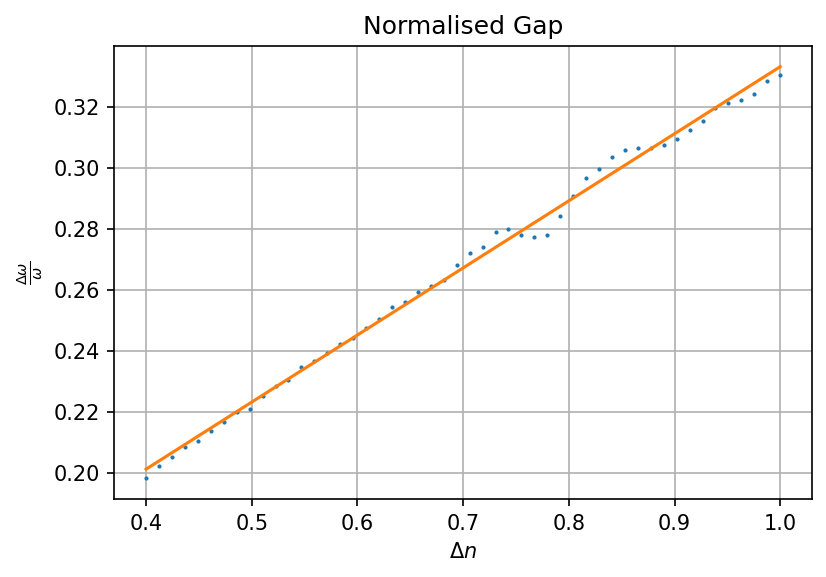

In [11]:
# Now make a figure 

delta_n = n_high_vec - np.ones(len(n_high_vec)) * n_low

slope, intercept, r, p, se = spst.linregress(delta_n, norm_gap, alternative='greater')

fig, ax = plt.subplots(dpi=150)
ax.plot(delta_n, norm_gap, ".", markersize = 2)
ax.plot(delta_n, intercept + delta_n * slope)
ax.set_xlabel(r"$\Delta n$")
ax.set_ylabel(r"$\frac{\Delta\omega}{\omega}$")
plt.title("Normalised Gap")
plt.grid()
plt.savefig("gap_dependence_restricted.png", dpi = 150, format="png")
plt.show()

# Now make the simulation with the defect inside

-----------
Initializing structure...
time for choose_chunkdivision = 0.000255108 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 16
     block, center = (1.68667,0,0)
          size (5.37333,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.586667,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (-0.173333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (0.24,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (0.653333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          diel

FloatProgress(value=0.0, description='0% done ', max=428.5714282989502)

Meep progress: 197.75/428.5714282989502 = 46.1% done in 4.0s, 4.7s to go
on time step 6338 (time=198.062), 0.000631179 s/step
Meep progress: 414.21875/428.5714282989502 = 96.7% done in 8.0s, 0.3s to go
on time step 13265 (time=414.531), 0.000577503 s/step
run 0 finished at t = 428.59375 (13715 timesteps)


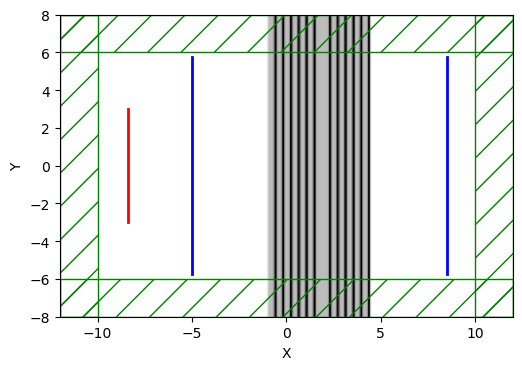

In [33]:
# First, reset meep 

sim.reset_meep()

n_low = 1.5
n_high = 2.4

# Now we define the geomtry. This has to be done iteratively. 1st layer at low index. 

# First, make a block of index n_low

resolution = 18

geometry = [mp.Block(
           mp.Vector3(thck, mp.inf, mp.inf), #
           center = mp.Vector3((dpml + space_front + thck/2) - sx/2 +1,0,0),  
           material = mp.Medium(index = n_low)) ] 


for jj in range(0, n_p):
    
    if jj != 6 : 
    
        geometry.append( 
            mp.Block(
               mp.Vector3(l_high, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + (jj+1)*period) -sx/2 +1, 0,0),  
               material = mp.Medium(index = n_high))
        )



# Now define a source

sources = [mp.Source(mp.GaussianSource(frequency=freq, fwidth = df), # Type of source
                     component = mp.Ez, 
                     size = mp.Vector3(0,6,0),
                     center = mp.Vector3(-sx/2 + 1.8*dpml,0))] # Position

# Boundary condition, we use PML layer

pml_layer = [mp.PML(dpml) ] 

# Define Simulation

sim = mp.Simulation(
      cell_size = cell,
      boundary_layers = pml_layer,
      geometry = geometry,
      sources = sources,
      resolution = res)

# Define Flux region for Transmitted Field

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 1.5, 0, 0), size = mp.Vector3(0,11.5,0) )
trans = sim.add_flux(freq, df, nfreq, tr_fr)

re_fr = mp.FluxRegion(center=mp.Vector3(-sx/2 + dpml + 5, 0, 0), size = mp.Vector3(0,11.5,0) )
refl = sim.add_flux(freq, df, nfreq, re_fr)

sim.load_minus_flux_data(refl, str_re_data)

# Run Simulation

sim.run(until_after_sources=400) 

# Now Get Fluxes

straight_tr_fl_2 = mp.get_fluxes(trans)
straight_re_fl_2 = mp.get_fluxes(refl)
fl_fr = mp.get_flux_freqs(refl)

# plot the dielectric structure 

plt.figure(dpi=100)
sim.plot2D()
plt.show()


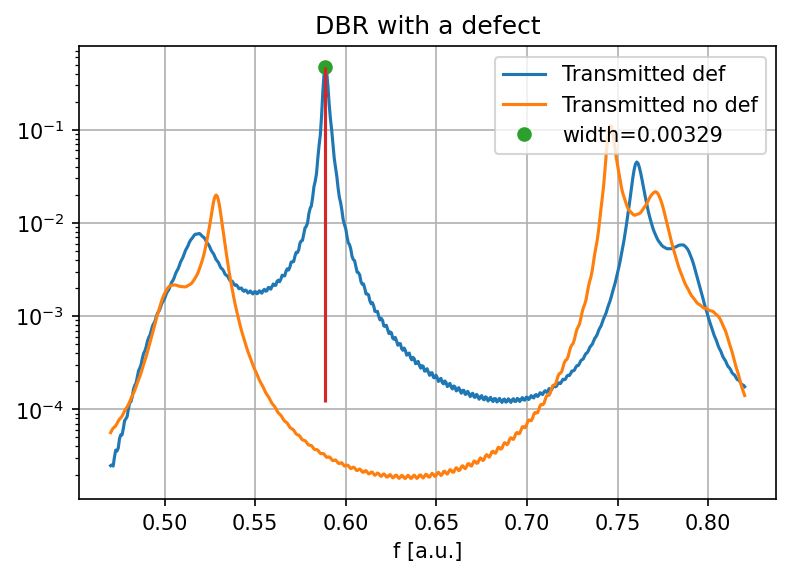

In [34]:
# Find the Peak

peak, properties = sp.find_peaks(straight_tr_fl_2, prominence = (0.3, None), width = [None, 10])

peak = peak[0]

fl_fr = np.array(fl_fr)

# plot the fluxes

fig = plt.figure(dpi = 150)

plt.plot(fl_fr, np.abs(straight_tr_fl_2), label="Transmitted def")
plt.plot(fl_fr, np.abs(straight_tr_fl), label="Transmitted no def")
plt.plot(fl_fr[peak], np.abs(straight_tr_fl_2)[peak], "o", label='width=%.5f' % (properties["widths"][0] * (fl_fr[1]-fl_fr[0]), ) )
plt.vlines(x=fl_fr[peak], ymin=straight_tr_fl_2[peak]-properties["prominences"], ymax=straight_tr_fl_2[peak], color = "C3")
plt.hlines(y=properties["width_heights"], xmin=fl_fr[int(np.ceil(properties["left_ips"][0]))], xmax=fl_fr[int(np.floor(properties["right_ips"][0]))], color="C3")
plt.xlabel("f [a.u.]")
plt.yscale("log")
plt.title("DBR with a defect")
plt.legend()
plt.grid()

plt.savefig("dbr_with_defect.png", dpi = 150, format = "png")

plt.show()


# Now we do it one more time... with 2 defects

-----------
Initializing structure...
time for choose_chunkdivision = 0.000213861 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 16
     block, center = (1.68667,0,0)
          size (5.37333,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.586667,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (-0.173333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (0.24,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (0.653333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          diel

FloatProgress(value=0.0, description='0% done ', max=428.5714282989502)

Meep progress: 192.71875/428.5714282989502 = 45.0% done in 4.0s, 4.9s to go
on time step 6177 (time=193.031), 0.000647845 s/step
Meep progress: 407.34375/428.5714282989502 = 95.0% done in 8.0s, 0.4s to go
on time step 13052 (time=407.875), 0.000581849 s/step
run 0 finished at t = 428.59375 (13715 timesteps)


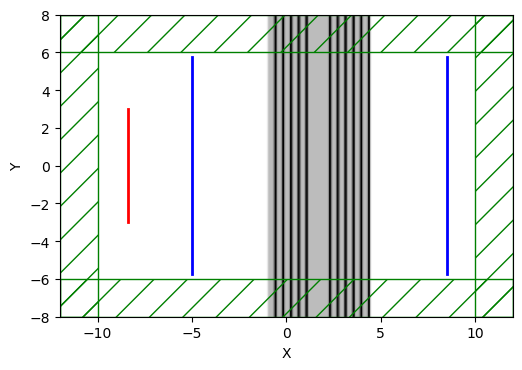

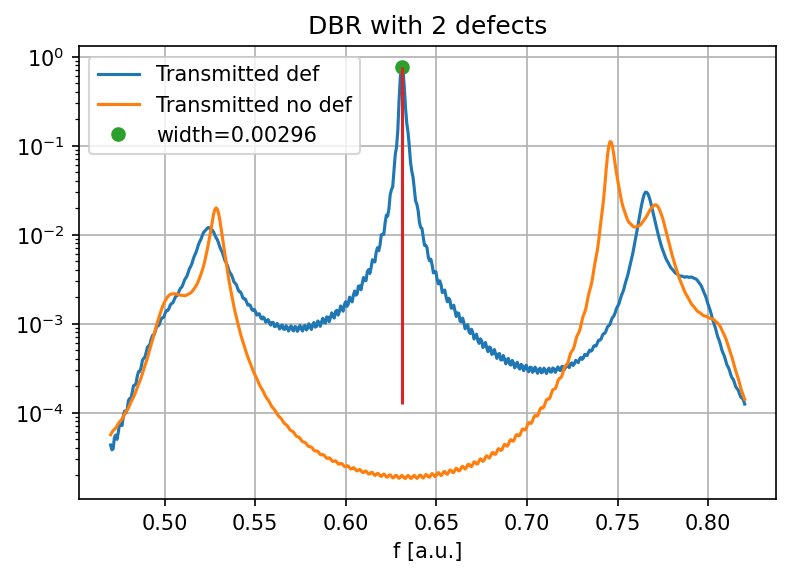

In [35]:
# First, reset meep 

sim.reset_meep()

n_low = 1.5
n_high = 2.4

# Now we define the geomtry. This has to be done iteratively. 1st layer at low index. 

# First, make a block of index n_low

resolution = 18

geometry = [mp.Block(
           mp.Vector3(thck, mp.inf, mp.inf), #
           center = mp.Vector3((dpml + space_front + thck/2) - sx/2 +1,0,0),  
           material = mp.Medium(index = n_low)) ] 


for jj in range(0, n_p):
    
    if (jj != 6 and jj !=5) : 
    
        geometry.append( 
            mp.Block(
               mp.Vector3(l_high, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + (jj+1)*period) -sx/2 +1, 0,0),  
               material = mp.Medium(index = n_high))
        )



# Now define a source

sources = [mp.Source(mp.GaussianSource(frequency=freq, fwidth = df), # Type of source
                     component = mp.Ez, 
                     size = mp.Vector3(0,6,0),
                     center = mp.Vector3(-sx/2 + 1.8*dpml,0))] # Position

# Boundary condition, we use PML layer

pml_layer = [mp.PML(dpml) ] 

# Define Simulation

sim = mp.Simulation(
      cell_size = cell,
      boundary_layers = pml_layer,
      geometry = geometry,
      sources = sources,
      resolution = res)

# Define Flux region for Transmitted Field

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 1.5, 0, 0), size = mp.Vector3(0,11.5,0) )
trans = sim.add_flux(freq, df, nfreq, tr_fr)

re_fr = mp.FluxRegion(center=mp.Vector3(-sx/2 + dpml + 5, 0, 0), size = mp.Vector3(0,11.5,0) )
refl = sim.add_flux(freq, df, nfreq, re_fr)

sim.load_minus_flux_data(refl, str_re_data)

# Run Simulation

sim.run(until_after_sources=400) 

# Now Get Fluxes

straight_tr_fl_2 = mp.get_fluxes(trans)
straight_re_fl_2 = mp.get_fluxes(refl)
fl_fr = mp.get_flux_freqs(refl)

# plot the dielectric structure 

plt.figure(dpi=100)
sim.plot2D()
plt.show()

# Find the Peak

peak, properties = sp.find_peaks(straight_tr_fl_2, prominence = (0.3, None), width = [None, 10])

peak = peak[0]

fl_fr = np.array(fl_fr)

# plot the fluxes

fig = plt.figure(dpi = 150)

plt.plot(fl_fr, np.abs(straight_tr_fl_2), label="Transmitted def")
plt.plot(fl_fr, np.abs(straight_tr_fl), label="Transmitted no def")
plt.plot(fl_fr[peak], np.abs(straight_tr_fl_2)[peak], "o", label='width=%.5f' % (properties["widths"][0] * (fl_fr[1]-fl_fr[0]), ) )
plt.vlines(x=fl_fr[peak], ymin=straight_tr_fl_2[peak]-properties["prominences"], ymax=straight_tr_fl_2[peak], color = "C3")
plt.hlines(y=properties["width_heights"], xmin=fl_fr[int(np.ceil(properties["left_ips"][0]))], xmax=fl_fr[int(np.floor(properties["right_ips"][0]))], color="C3")
plt.xlabel("f [a.u.]")
plt.yscale("log")
plt.title("DBR with 2 defects")
plt.legend()
plt.grid()

plt.savefig("dbr_with_2_defects.png", dpi = 150, format = "png")

plt.show()



# And one more, with four of them 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000252962 s
Working in 2D dimensions.
Computational cell is 24 x 16 x 0 with resolution 16
     block, center = (1.68667,0,0)
          size (5.37333,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.25,2.25,2.25)
     block, center = (-0.586667,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (-0.173333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (0.24,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.76,5.76,5.76)
     block, center = (0.653333,0,0)
          size (0.155,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          diel

FloatProgress(value=0.0, description='0% done ', max=428.5714282989502)

Meep progress: 189.625/428.5714282989502 = 44.2% done in 4.0s, 5.0s to go
on time step 6075 (time=189.844), 0.000658457 s/step
Meep progress: 391.34375/428.5714282989502 = 91.3% done in 8.0s, 0.8s to go
on time step 12533 (time=391.656), 0.000619552 s/step
run 0 finished at t = 428.59375 (13715 timesteps)


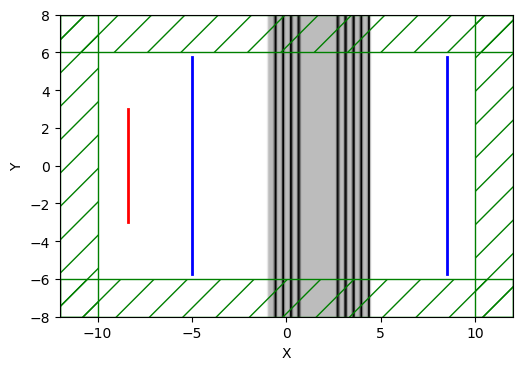

In [36]:
# First, reset meep 

sim.reset_meep()

n_low = 1.5
n_high = 2.4

# Now we define the geomtry. This has to be done iteratively. 1st layer at low index. 

# First, make a block of index n_low

resolution = 18

geometry = [mp.Block(
           mp.Vector3(thck, mp.inf, mp.inf), #
           center = mp.Vector3((dpml + space_front + thck/2) - sx/2 +1,0,0),  
           material = mp.Medium(index = n_low)) ] 


for jj in range(0, n_p):
    
    if (jj != 4 and jj != 6 and jj !=5 and jj != 7) : 
    
        geometry.append( 
            mp.Block(
               mp.Vector3(l_high, mp.inf, mp.inf), #
               center = mp.Vector3((dpml + space_front + (jj+1)*period) -sx/2 +1, 0,0),  
               material = mp.Medium(index = n_high))
        )



# Now define a source

sources = [mp.Source(mp.GaussianSource(frequency=freq, fwidth = df), # Type of source
                     component = mp.Ez, 
                     size = mp.Vector3(0,6,0),
                     center = mp.Vector3(-sx/2 + 1.8*dpml,0))] # Position

# Boundary condition, we use PML layer

pml_layer = [mp.PML(dpml) ] 

# Define Simulation

sim = mp.Simulation(
      cell_size = cell,
      boundary_layers = pml_layer,
      geometry = geometry,
      sources = sources,
      resolution = res)

# Define Flux region for Transmitted Field

tr_fr = mp.FluxRegion(center=mp.Vector3(sx/2 - dpml - 1.5, 0, 0), size = mp.Vector3(0,11.5,0) )
trans = sim.add_flux(freq, df, nfreq, tr_fr)

re_fr = mp.FluxRegion(center=mp.Vector3(-sx/2 + dpml + 5, 0, 0), size = mp.Vector3(0,11.5,0) )
refl = sim.add_flux(freq, df, nfreq, re_fr)

sim.load_minus_flux_data(refl, str_re_data)

# Run Simulation

sim.run(until_after_sources=400) 

# Now Get Fluxes

straight_tr_fl_2 = mp.get_fluxes(trans)
straight_re_fl_2 = mp.get_fluxes(refl)
fl_fr = mp.get_flux_freqs(refl)

# plot the dielectric structure 

plt.figure(dpi=100)
sim.plot2D()
plt.show()



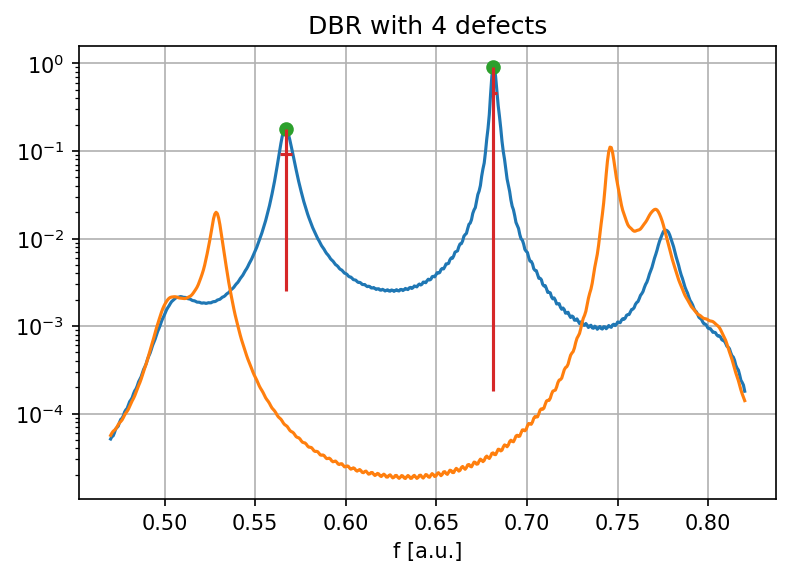

In [37]:
# Find the Peak

peaks, properties = sp.find_peaks(straight_tr_fl_2, prominence = (0.1,1), width = [5, None])

fl_fr = np.array(fl_fr)

# plot the fluxes

fig = plt.figure(dpi = 150)

plt.plot(fl_fr, np.abs(straight_tr_fl_2), label="Transmitted def")
plt.plot(fl_fr, np.abs(straight_tr_fl), label="Transmitted no def")
plt.plot(fl_fr[peaks], np.abs(straight_tr_fl_2)[peaks], "o" )
plt.vlines(x=fl_fr[peaks][0], ymin=straight_tr_fl_2[peaks[0]]-properties["prominences"][0], ymax=straight_tr_fl_2[peaks[0]], color = "C3")
plt.vlines(x=fl_fr[peaks][1], ymin=straight_tr_fl_2[peaks[1]]-properties["prominences"][1], ymax=straight_tr_fl_2[peaks[1]], color = "C3")
plt.hlines(y=properties["width_heights"][0], xmin=fl_fr[int(np.ceil(properties["left_ips"][0]))], xmax=fl_fr[int(np.floor(properties["right_ips"][0]))], color="C3")
plt.hlines(y=properties["width_heights"][1], xmin=fl_fr[int(np.ceil(properties["left_ips"][1]))], xmax=fl_fr[int(np.floor(properties["right_ips"][1]))], color="C3")
plt.xlabel("f [a.u.]")
plt.yscale("log")
plt.title("DBR with 4 defects")
plt.grid()

plt.savefig("dbr_with_4_defects.png", dpi = 150, format = "png")

plt.show()